This script aims to calculate and plot the dispersion of anti-resonant hollowcore fibre based on the results in 'Analytic model for the complex
effective index of the leaky modes of tube-type anti-resonant hollowcore fibers', Zeisberger et al.

The main equation we wish to model is:
$$ Re(n_{\textrm{\textit{eff}}}) = n_a - \frac{j^2}{2k_0^2n_a R^2} - \frac{j^2}{k_0^3 n_a^2 R^3}\frac{\cot(\phi)}{\sqrt{\varepsilon - 1}}\frac{(\varepsilon + 1)}{2}$$
for $HE_{11}$. In this equation, $n_a \approx 1$ is the refractive index of air, 


$\phi = k_0 \omega \sqrt{n_g^2 - n_a^2} \left(1 + O\left(\frac{\kappa}{k_0}\right)^2\right)$,  $k_0$ is the longditudinal $k$ vector in vacuum $\omega / c$
and $\varepsilon = n_g^2 / n_a^2$ with $n_g$ being the refractive index of the glass capillary.

$R$ is the core diameter ($\approx 20 \mu m$), and $j = j_{m-1,n}$ represents the $n$-th root of the Bessel function (of order $m$) $j_m$; i.e. the 1st root of $j_0$.

Libraries:

In [1]:
import RefractiveIndexClass as ri
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from scipy.special import jn_zeros
def find_bessel_zero(m, n):
    # m is the order of the Bessel function
    # n is the index of the zero (0-based)

    # Using jn_zeros to get the zeros of the Bessel function
    zeros = jn_zeros(m, n+1)  # n+1 because the function is 0-indexed

    # Return the nth zero
    return zeros[n]

Define the key parameters:

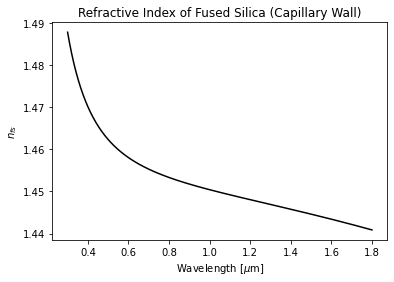

(0.365, 1.45)

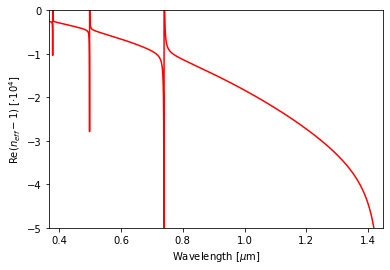

In [19]:
mode = [1, 1]                                               # Mode of propagation, HE_nm
name_of_mode = "HE_" + str(mode[0]) + "," + str(mode[1])    # Name of propagation mode
c = 3e8                                                     # Speed of light [m/s]
lambda_min = 300e-9                                         # [m]
lambda_max = 1800e-9                                        # [m]
N = 10000                                                   # Number of points
lambdas = np.linspace(lambda_min, lambda_max, N)            # Define wavelength range in m
n_a = 1.0                                                   # Refractive index of air
jz = find_bessel_zero(mode[0] - 1, mode[1] - 1)             # for j_(m-1),n where the nth root here is the "first root of the function", i.e. the zeroth root of Bessel funciton on order m
k_0_lambda = 2 * np.pi / lambdas                            # Vacuum wavenumber 

# Fibre parameters:
R = 20e-6                                                   # Radius of fibre core [m]                  
w=0.7e-6                                                    # Wall thickness [m]
n_g_name = "fused silica"                                   # Name of refractive index of capillary for text file
# n_g_lambda = 1.45 * np.ones(len(lambdas))                   # Constant 1.45
n_g_lambda = ri.RefractiveIndex.n_fs(lambdas*1e9, parameter="wavelength") # Refractive index of fused silica

# Plot of refractive index of capillary walls
plt.plot(lambdas*1e6, n_g_lambda, color = 'k')
plt.title("Refractive Index of Fused Silica (Capillary Wall)")
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("$n_{fs}$")
plt.show()

# Computing the refractive index from Eq. 25 in paper
phi_lambda = k_0_lambda * w * np.sqrt(n_g_lambda**2 - n_a**2)
epsilon_lambda = n_g_lambda**2/(n_a**2)
n_eff_lambda = n_a -(jz**2)/(2 * k_0_lambda**2 * n_a * R**2) - (jz**2)/(k_0_lambda**3 * n_a**2 * R**3)*(1)/(np.tan(phi_lambda) * np.sqrt(epsilon_lambda - 1))*((epsilon_lambda + 1))/(2)
# n_eff_lambda_function = lambda x: n_a -(jz**2)/(2 * (2 * np.pi / x)**2 * n_a * R**2) - (jz**2)/((2 * np.pi / x)**3 * n_a**2 * R**3)*(1)/(np.tan((2 * np.pi / x) * w * np.sqrt(ri.RefractiveIndex.n_fs(x)**2 - n_a**2)) * np.sqrt(ri.RefractiveIndex.n_fs(x)**2/n_a**2 - 1))*((ri.RefractiveIndex.n_fs(x)**2 / n_a**2 + 1))/(2)
# Plot of real effective refractive index
plt.plot(lambdas*1e6, (n_eff_lambda-1)*1e4, color = 'r')
plt.ylabel("Re($n_{eff}-1$) [$\cdot 10^4$]")
plt.xlabel("Wavelength [$\mu$m]")
plt.ylim([-5,0])
plt.xlim([0.365, 1.450])

Save this dispersion data to a csv:

In [45]:
import DataAnalysisClass as da

preamble = f'''Data for the dispersion of leaky mode in HCF as per Zeisberger, 
Analytic model for the complex effective index of the leaky modes of tube-type 
anti-resonant hollow core fibers, 2017.

Parameters:
Name of mode: {name_of_mode},
Min wavelength: {lambda_min * 1e6} [um],
Max wavelength: {lambda_max * 1e6} [um],
Number of points: {N},
n_g: {n_g_name},
Core radius, R: {R * 1e6} [um],
Capillary thickness, w: {w * 1e6} [um].  
* [u = micro] *

'''
da.DataHandling.write_csv("./leaky-mode-hcf-dispersion-data-lambda.csv", [lambdas, n_eff_lambda], ["Wavelength [nm]", "Re_n_eff"], preamble=[preamble])

Delta phi coefficients:  [ 1.49682508e-06 -6.03751668e-03  8.26808473e+00 -4.82277406e+03]


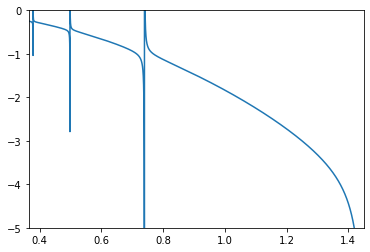

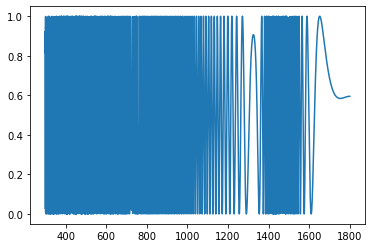

In [18]:
# Define the lambda function for n_eff
n_eff_lambda_function = np.vectorize(lambda x: (
    n_a - (jz**2) / (2 * (2 * np.pi / x)**2 * n_a * R**2) -
    (jz**2) / ((2 * np.pi / x)**3 * n_a**2 * R**3) * (1) /
    (np.tan((2 * np.pi / x) * w * np.sqrt(ri.RefractiveIndex.n_fs(x*1e9)**2 - n_a**2)) *
     np.sqrt(ri.RefractiveIndex.n_fs(x*1e9)**2 / n_a**2 - 1)) *
    ((ri.RefractiveIndex.n_fs(x*1e9)**2 / n_a**2 + 1)) / 2
) if np.abs((2 * np.pi / x)**2 * n_a * R**2) > 1e-10 and \
    np.abs(((2 * np.pi / x)**3 * n_a**2 * R**3) *
           (np.tan((2 * np.pi / x) * w * np.sqrt(ri.RefractiveIndex.n_fs(x*1e9)**2 - n_a**2)) *
            np.sqrt(ri.RefractiveIndex.n_fs(x*1e9)**2 / n_a**2 - 1)) *
           ((ri.RefractiveIndex.n_fs(x*1e9)**2 / n_a**2 + 1)) / 2) > 1e-10 \
    else np.nan
)

# Check that this looks right
plt.plot(lambdas*1e6, (n_eff_lambda_function(lambdas) - 1)*1e4)
plt.ylim([-5,0])
plt.xlim([0.365, 1.450])

import Functions as f
si = f.SpectralInterferometry()
n_eff_lambda_function_nm = lambda x: n_eff_lambda_function(x*1e-9)
[wavelengths, spectral_interference_data_points, delta_phi_fit_coefficients] = si.SimulateInterference(wavelengths=lambdas*1e9, zero_delay_wavelength=1800, central_wavelength=700, L_f=0.2, fibre_refractive_index_function=n_eff_lambda_function_nm, show_plots=True)
# si.SimulateInterference(wavelengths=np.linspace(950, 1130, 10000), zero_delay_wavelength=1280, central_wavelength=1040, L_f=0.2, show_plots=True)

/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Functions.py:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


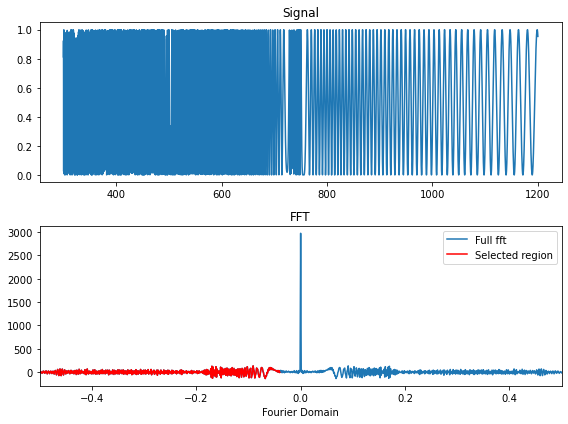

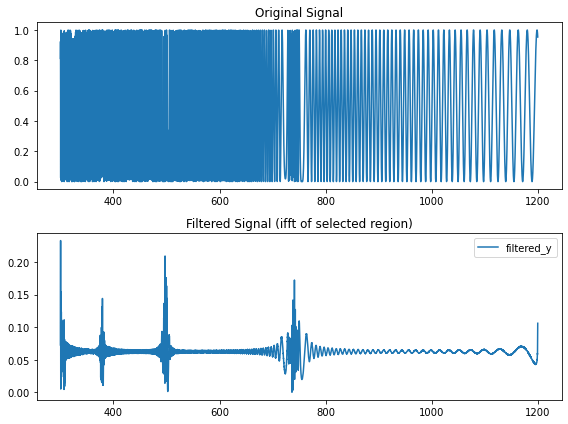

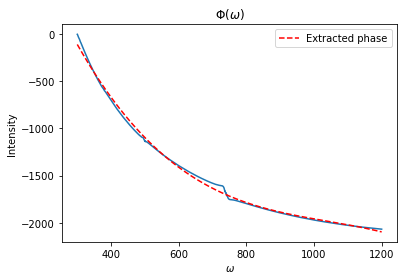

In [25]:
sif = f.SI_Functions()# keep_min_freq=0.01 fft_x_lim = [-0.5, 0.5]
indices = np.where((wavelengths >= min(wavelengths)) & (wavelengths <= 1200))[0]
wavelengths = wavelengths[indices]
spectral_interference_data_points = spectral_interference_data_points[indices]
[x, coefficients] = sif.DeltaPhiRetrievalProcedure(x=wavelengths, y=spectral_interference_data_points, order = 3, keep_min_freq = 0.04, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-0.5, 0.5])
phi = lambda var: np.poly1d(coefficients)(var)